# Apple Watch Health Data

This project is an exploration of the data collected by my Apple Watch over the course of about one year.

In [761]:
import pandas as pd
import seaborn as sns
from dateutil import parser
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

# Parsing Apple Watch XML Data

The iOS Health app has as function that lets a user dump all of the data collected into an XML file. 

# Heartrate Data

In [705]:
# Resting HR from Apple Watch
resting_hr = pd.read_csv('HKQuantityTypeIdentifierRestingHeartRate.csv', parse_dates=True, index_col='Date')

In [707]:
resting_hr.head()

,Value,Unit
Date,,
2020-10-13 22:40:41-07:00,65,count/min
2020-10-14 21:19:02-07:00,63,count/min
2020-10-15 18:58:04-07:00,64,count/min
2020-10-16 22:41:50-07:00,55,count/min
2020-10-17 21:10:58-07:00,55,count/min


In [708]:
hr_mean = resting_hr['Value'].mean(axis=0)

In [709]:
resting_hr.iplot(y='Value', yTitle='Resting HR')

In [710]:
# There should only be 324 entries, so there are duplicates
resting_hr = resting_hr.resample('D').sum()

# 71 is the highest value, so any values above that will be duplicated for that particular day
# all of these are duplicate entires, so replace these with the average resting HR
resting_hr['Value'] = resting_hr['Value'].apply(lambda x: hr_mean if x > 71.0 else x)
resting_hr.loc[resting_hr['Value'] == 0.0] = hr_mean 


# Weather Data

In [621]:
# Weather https://www.ncdc.noaa.gov/cdo-web/
weather = pd.read_csv('2700509.csv', parse_dates=True, index_col='DATE')
weather.head()
weather = weather[['TMAX']]
#weather['DATE'] = pd.to_datetime(weather['DATE'])

In [623]:
weather.iplot(y='TMAX', yTitle='Maximum temperature (\u00B0F)')

# Strava Data

In [630]:
distance = pd.read_csv('HKQuantityTypeIdentifierDistanceWalkingRunning.csv', parse_dates=True, index_col='Date')

In [632]:
# Convert datetime strings to datetime objects
distance.head()

# Because the Apple Watch records small intervals of activity over the course of a day, the pandas resample method can be used to get a sum of distance walked/ran over each day
dist2 = distance.resample('D').sum()
dist2.iplot(yTitle='Distance walk+run (mi)')
# There's something wrong with this plot. The longest distance I've run is a half marathon, but according to this graph, I've walked/run more than one.
# Let's see what's going on with the data.

In [636]:
# Let's look at January 3, 2021
mask = (distance.index >= '2021-01-03') & (distance.index < '2021-01-04')
df = distance.loc[mask]


df[df['Value'] > 1.0]

# It looks like when you record an activity, the Apple Watch dumps it all at once. There's clearly some GPS weirdness going on, so let's filter out any distances < 1.0 mi
#distance[distance['Value'] >= 1.0].iplot()

,Value,Unit
Date,,
2021-01-03 18:04:34-07:00,7.0256,mi


In [637]:
distance[distance['Value'] > 1.0].iplot(y='Value', yTitle='Distance walk+run (mi)')
# The numbers still aren't adding up. Luckily, I have consistently tracked my workouts with Strava, so I'll use that data instead.

In [735]:
# Some activities were manually added to this spreadsheet
strava = pd.read_csv('activities.csv', parse_dates=True, index_col='Activity Date')

In [736]:
strava.head()

,Activity ID,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Relative Effort,Commute,Activity Gear,Filename,...,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>"
Activity Date,,,,,,,,,,,,,,,,,,,,,
2017-03-21 23:20:20,9.094840e+08,Afternoon Ride,Ride,NaN,756.0,3.97,NaN,False,NaN,activities/909484019.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-08 22:31:55,9.337941e+08,Afternoon Ride,Ride,NaN,2277.0,13.02,NaN,False,NaN,activities/933794093.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-15 20:33:59,9.440155e+08,Afternoon Ride,Ride,NaN,8134.0,49.33,NaN,False,NaN,activities/944015496.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-10 19:47:51,1.226077e+09,Lunch Ride,Ride,NaN,1740.0,0.63,NaN,False,NaN,activities/1226076972.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-11 19:32:55,1.226078e+09,Yosemite,Ride,NaN,15329.0,12.53,NaN,False,NaN,activities/1226077715.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [737]:
# I want a few statistics that might be related to metrics that the Apple Watch tracks, like sleep time or resting heartrate.
strava = strava[['Activity Type', 'Elapsed Time', 'Distance', 'Elevation Gain', 'Average Grade', 'Average Speed']]


In [738]:
# Filter out any data from before the Apple Watch data (October 13, 2020)
strava = strava.loc[strava.index >= '2020-10-13']

In [739]:
# Strava's data is in SI units. Convert to Imperial units. 
strava['Distance'] = strava['Distance'] / 1.60934  # km to mi
strava['Elevation Gain'] = strava['Elevation Gain'] * 3.28084  # m to ft
strava['Average Speed'] = strava['Average Speed'] / 0.621371  # km/h to mi/
strava['Elapsed Time'] = strava['Elapsed Time'] / 3600.0  # seconds to hours

# It's possible to have multiple activities per day. This should be a pretty rare occurrance
strava = strava.resample('D').sum()

In [740]:
strava.iplot(y='Distance')

In [741]:
strava['Distance']

Activity Date
2020-10-13    3.150008
2020-10-14    0.000000
2020-10-15    0.000000
2020-10-16    7.140000
2020-10-17    0.000000
                ...   
2021-08-27    6.300720
2021-08-28    0.000000
2021-08-29    0.000000
2021-08-30    8.115128
2021-08-31    5.368660
Freq: D, Name: Distance, Length: 323, dtype: float64

# Sleep data

In [666]:
# Sleep
# Apple Watch tends to greatly overestimate the amount of sleep I get. If I'm reading in bed, it usually counts that as sleep.
# I use an app called AutoSleep instead--it's fairly accurate. I've only been using it since December 2020, so I'll have to make an educated guess to fill in October 2020-November 2020
sleep = pd.read_csv('AutoSleep.csv', parse_dates=True, index_col='toDate')
sleep = sleep[['asleep']]

# Need to convert the "asleep" column from hh:mm:ss to decimal hours
def to_hours(t):
    temp = t.split(':')
    
    # convert to hours
    hours = float(temp[0])
    minutes = float(temp[1]) / 60.0
    seconds = float(temp[2]) / 3600.0
    
    return hours + minutes + seconds

sleep.head()


,asleep
toDate,
2020-12-06,7:57:00
2020-12-07,7:37:00
2020-12-08,9:02:00
2020-12-09,8:39:00
2020-12-10,8:39:00


In [667]:
sleep['asleep'] = sleep['asleep'].apply(to_hours)
sleep.iplot(y='asleep', yTitle='Time asleep (hours)')

In [668]:
sleep_mean = sleep['asleep'].mean(axis=0)

In [669]:
# I'll fill in the missing data by taking the average of the sleep data I have starting on December 6, 2020.
dates = pd.date_range(start='10/13/2020', end='12/5/2020', freq='D')
time_asleep = [sleep_mean] * len(dates)
pd.DataFrame(index=dates, data=time_asleep, columns=['asleep'])
sleep = pd.concat([pd.DataFrame(index=dates, data=time_asleep, columns=['asleep']), sleep])

,asleep
2020-10-13,8.017688
2020-10-14,8.017688
2020-10-15,8.017688
2020-10-16,8.017688
2020-10-17,8.017688


In [670]:
sleep.iplot(y='asleep', yTitle='Time asleep (hours)')

In [671]:
# There should be 323 entires, one for each day. Resample and sum so any missing time series rows are now 0
# Any 0's are from when I didn't wear the watch to bed. Replace them with the mean time asleep, 7.95 hours.
sleep = sleep.resample('D').sum()
sleep.loc[sleep['asleep'] == 0.0] = sleep_mean

# Stand Time

In [791]:
stand_time = pd.read_csv('HKQuantityTypeIdentifierAppleStandTime.csv', parse_dates=True, index_col='Date')
stand_time = stand_time.resample('D').sum() / 60.0
stand_time.iplot(yTitle='Standing time (hours)')

# Putting It All Together

In [786]:
# Putting it all together

# Change indices to naive timestamps and concatenate
df = pd.concat([weather.tz_localize(None), resting_hr.tz_localize(None), sleep.tz_localize(None), strava['Distance'].tz_localize(None), stand_time.tz_localize(None)], axis=1)

In [788]:
# Check for any NaNs
df.isnull().values.any()

False

In [792]:
# Rename columns to something more descriptive
df = df.rename(columns={"TMAX": "Temperature High (\u00B0F)", "Value": "Resting HR (BPM)", "asleep": "Time Asleep (hours)", "Distance": "Distance (mi)", "Stand time": "Stand time (hours)"})

<AxesSubplot:>

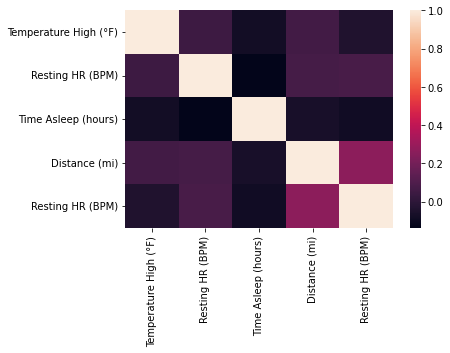

In [797]:
sns.heatmap(df.corr())